In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

In [4]:
def collect_layer_wise_losses(d):
    losses = {}
    for layer, results in d.items():
        if layer == "linear":
            continue

        losses[layer] = {}
        
        for k, v in results.items():
            
            if "ts" in k:
                losses[layer][k.replace('_score_test', '')] = v
                
    return losses

def collect_losses(root_dir):

    depth = 7

    dict_res_roberta = dict()
    dict_res_xlm = dict()
    
    for subdir, dirs, files in os.walk(root_dir):
        if subdir[len(root_dir):].count(os.sep) < depth:
            for file_ in files:
                if file_ == "probe_results.json":
                    with open(subdir + "/" + file_) as f:
                        d = json.load(f)
                    
                    folder_name_split = subdir.split(os.sep)[-1].split("_")
                    model_type = subdir.split(os.sep)[-2]
                    dataset_name = folder_name_split[2] if len(folder_name_split) > 2 else "en"
                    pretrained = folder_name_split[0]
                                        
                    if model_type == "roberta":
                        if not dataset_name in dict_res_roberta:
                            dict_res_roberta[dataset_name] = {}
                        dict_res_roberta[dataset_name][pretrained] = collect_layer_wise_losses(d)
                    elif model_type == "xlm":
                        if not dataset_name in dict_res_xlm:
                            dict_res_xlm[dataset_name] = {}
                        dict_res_xlm[dataset_name][pretrained] = collect_layer_wise_losses(d)

    return dict_res_roberta, dict_res_xlm


def print_probe_results(dict_res):
    mean_dataset = []
    
    en_dataset = None

    for dataset, res in dict_res.items(): # cicle over users
        res_d_p = pd.DataFrame(res["p"])
                
        if not dataset == "en":
            mean_dataset.append(res_d_p.loc["loss_ts"])
        else:
            en_dataset = res_d_p.loc["loss_ts"]
        
        # print(f"Dataset: {dataset}")
        # plt.plot(res_d_p.loc["loss_ts"], label="pretrained")
        # plt.legend()
        # plt.show()
        
    # mean over the users
    print(f"AVERAGED-Dataset")
    x_p = np.mean(np.array(mean_dataset), 0)
    std_p = np.std(np.array(mean_dataset), 0)
    plt.plot(range(len(x_p)), x_p, label="finetuned")
    plt.fill_between(range(len(x_p)), x_p-std_p, x_p+std_p, alpha=0.2)

    plt.plot(en_dataset, label="not finetuned")
    
    plt.legend()
    plt.show()

In [5]:
dict_res_roberta, dict_res_xlm = collect_losses("../output/ds_probe/sst2")

{'linear': True, '0': {'loss_tr': 0.5578256544269403, 'loss_ts': 0.5091743119266054}, '1': {'loss_tr': 0.8066044039258192, 'loss_ts': 0.7717889908256881}, '2': {'loss_tr': 0.7927511915544403, 'loss_ts': 0.7534403669724771}, '3': {'loss_tr': 0.7939538820175503, 'loss_ts': 0.7752293577981652}, '4': {'loss_tr': 0.8208882091790524, 'loss_ts': 0.8084862385321101}, '5': {'loss_tr': 0.8333605547224161, 'loss_ts': 0.8211009174311926}, '6': {'loss_tr': 0.8440511366167278, 'loss_ts': 0.8463302752293578}, '7': {'loss_tr': 0.8489658346820295, 'loss_ts': 0.8314220183486238}, '8': {'loss_tr': 0.8494855157463362, 'loss_ts': 0.8325688073394495}, '9': {'loss_tr': 0.8428484461536178, 'loss_ts': 0.8405963302752294}, '10': {'loss_tr': 0.8320242319856271, 'loss_ts': 0.8360091743119266}, '11': {'loss_tr': 0.8167307606645978, 'loss_ts': 0.8268348623853211}}
{'linear': True, '0': {'loss_tr': 0.5578256544269403, 'loss_ts': 0.5091743119266054}, '1': {'loss_tr': 0.8051938410369864, 'loss_ts': 0.7706422018348624}

## ROBERTA Results

AVERAGED-Dataset


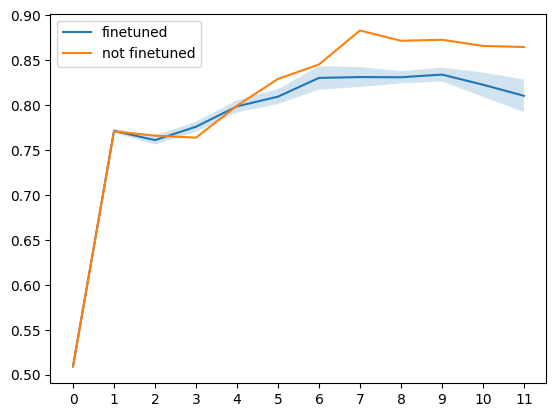

In [6]:
print_probe_results(dict_res_roberta)

## XLM Results

Dataset: it_26 - Features: skip


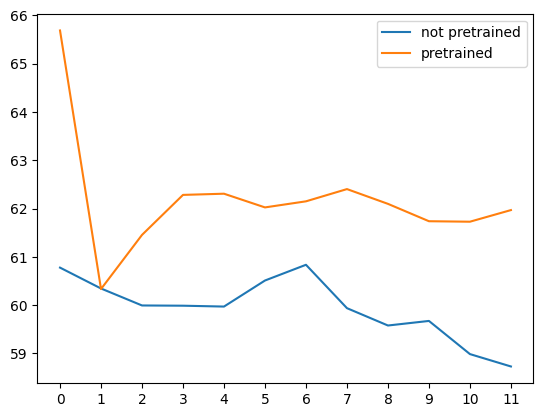

Dataset: it_26 - Features: firstfix_dur


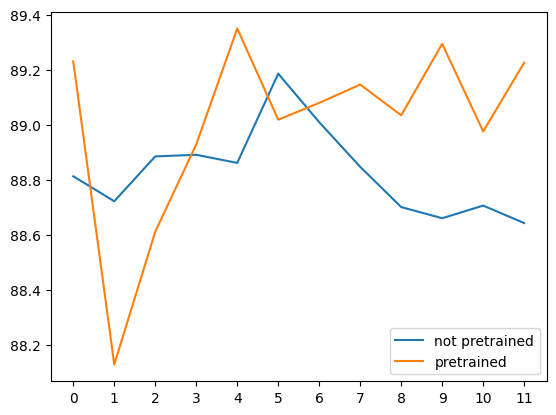

Dataset: it_26 - Features: firstrun_dur


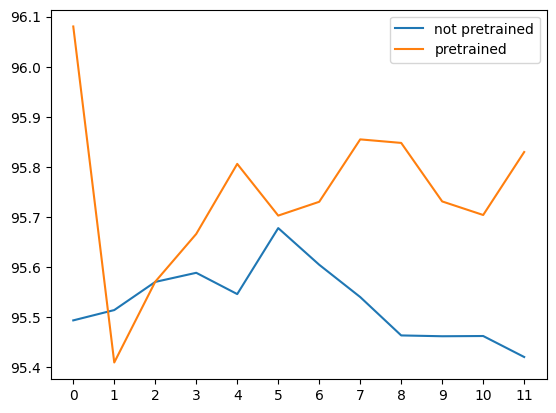

Dataset: it_26 - Features: dur


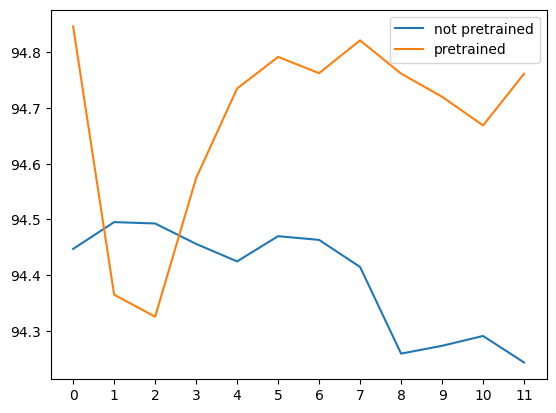

Dataset: it_26 - Features: firstrun_nfix


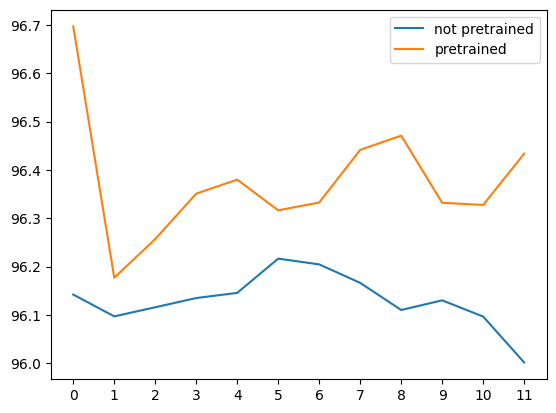

Dataset: it_26 - Features: nfix


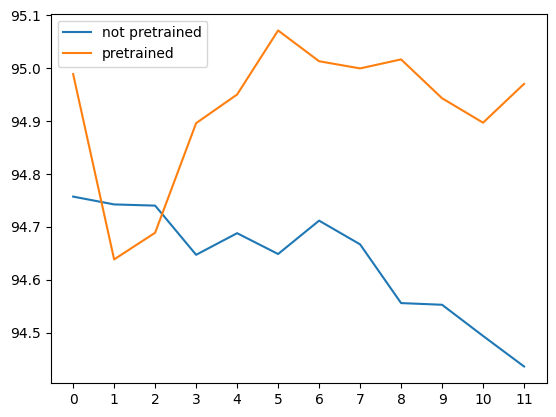

Dataset: it_26 - Features: refix


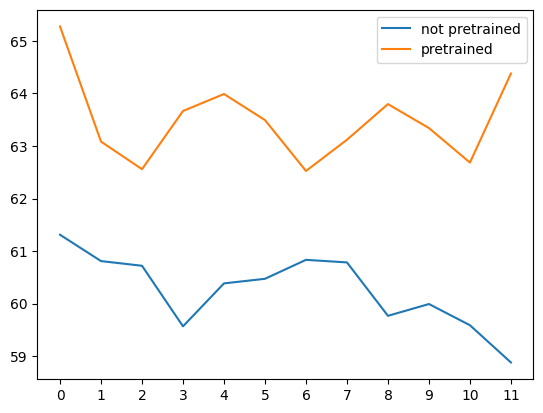

Dataset: it_26 - Features: reread


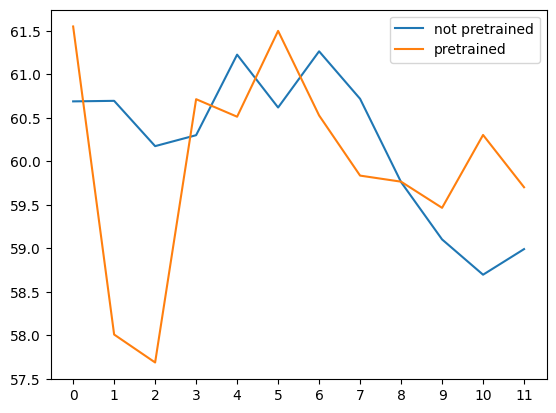

Dataset: en_57 - Features: skip


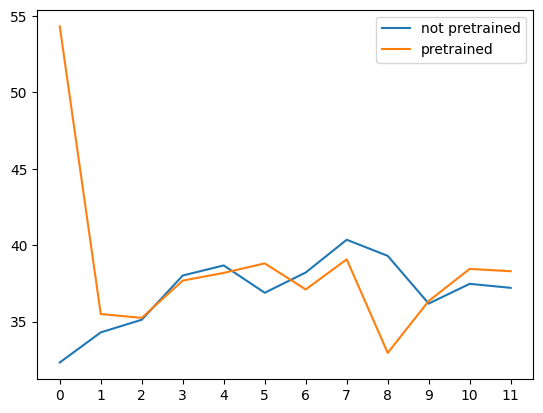

Dataset: en_57 - Features: firstfix_dur


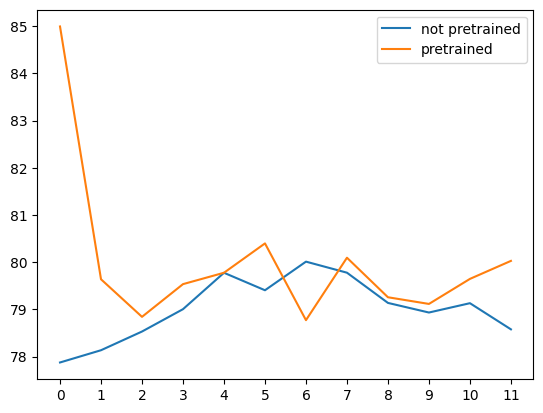

Dataset: en_57 - Features: firstrun_dur


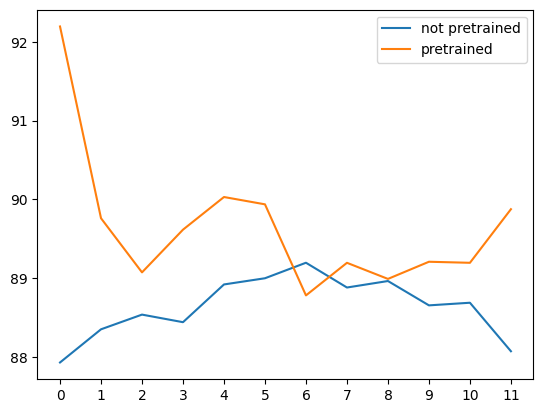

Dataset: en_57 - Features: dur


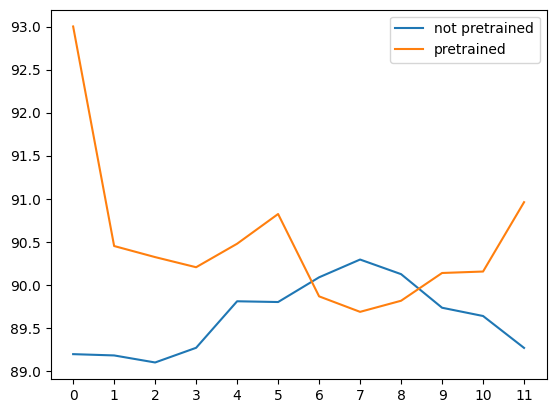

Dataset: en_57 - Features: firstrun_nfix


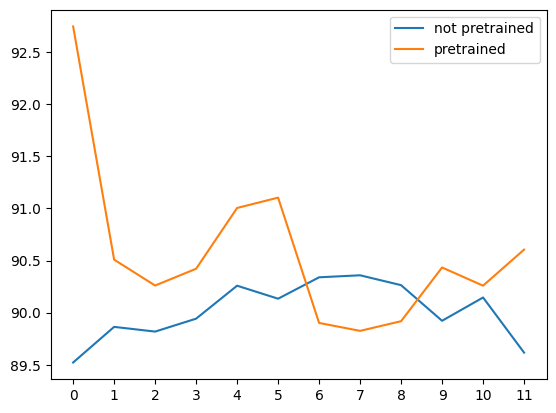

Dataset: en_57 - Features: nfix


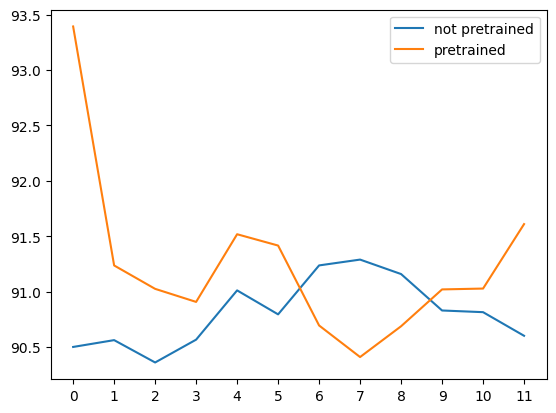

Dataset: en_57 - Features: refix


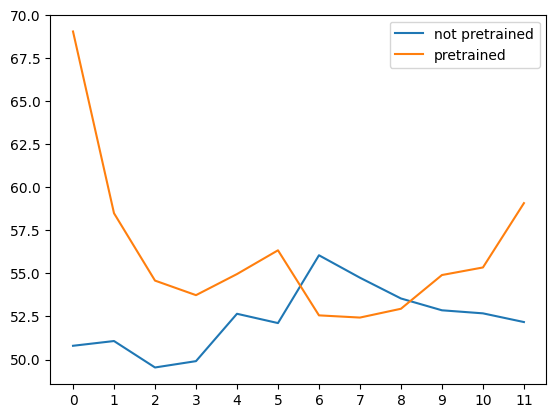

Dataset: en_57 - Features: reread


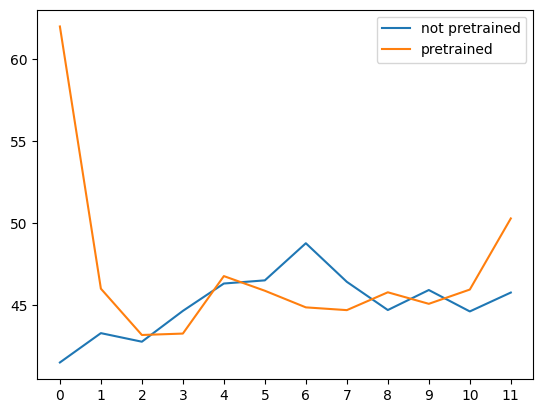

Dataset: it_43 - Features: skip


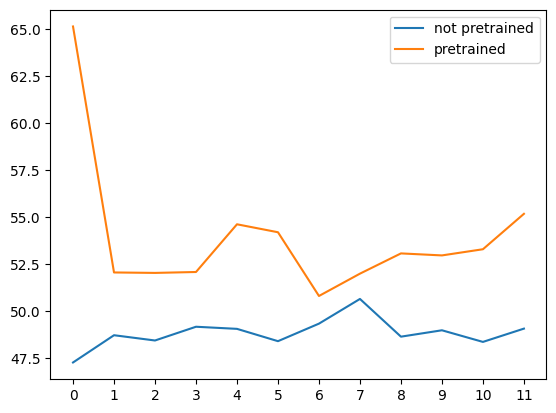

Dataset: it_43 - Features: firstfix_dur


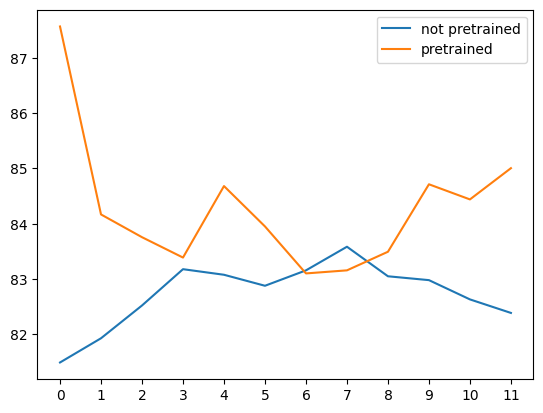

Dataset: it_43 - Features: firstrun_dur


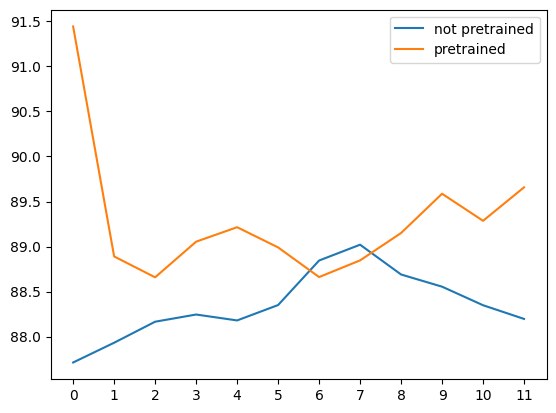

Dataset: it_43 - Features: dur


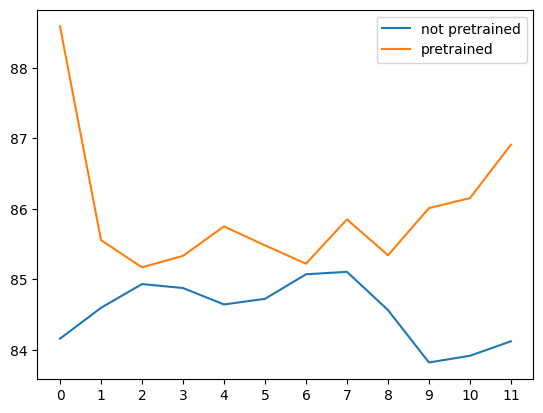

Dataset: it_43 - Features: firstrun_nfix


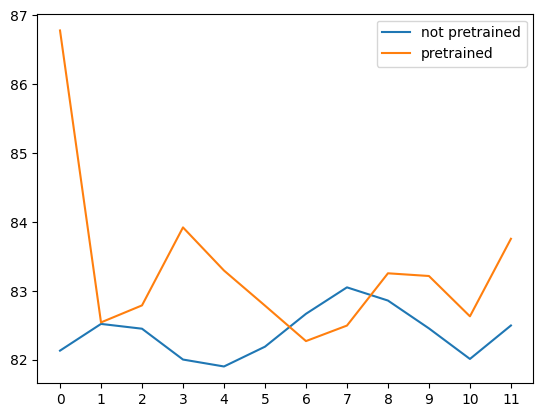

Dataset: it_43 - Features: nfix


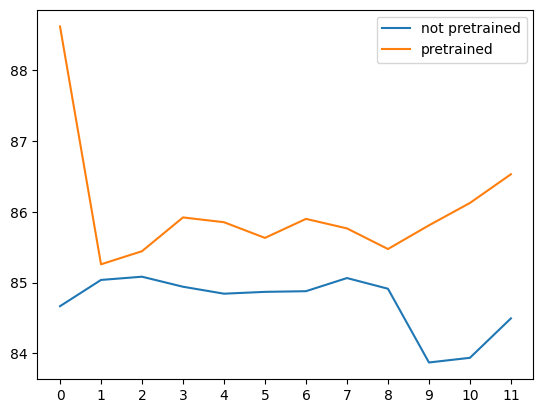

Dataset: it_43 - Features: refix


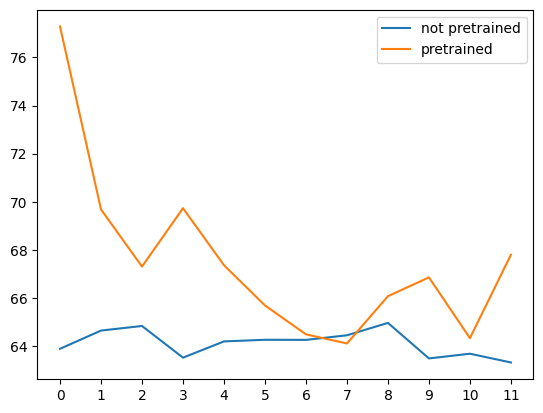

Dataset: it_43 - Features: reread


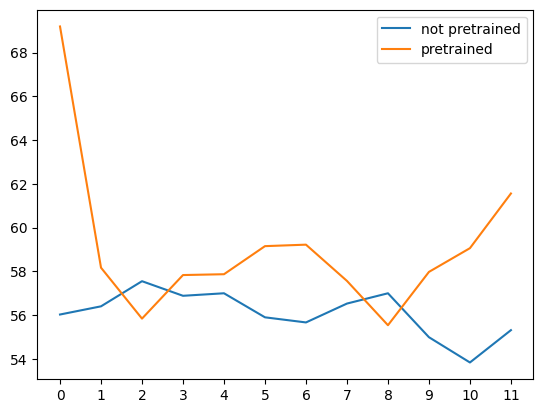

Dataset: en_6 - Features: skip


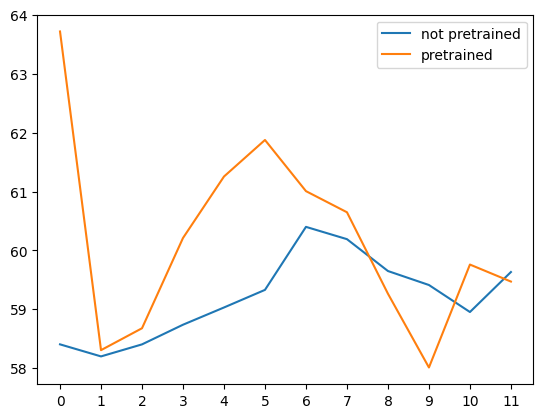

Dataset: en_6 - Features: firstfix_dur


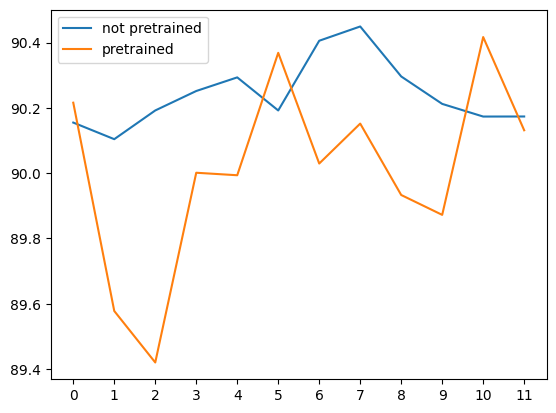

Dataset: en_6 - Features: firstrun_dur


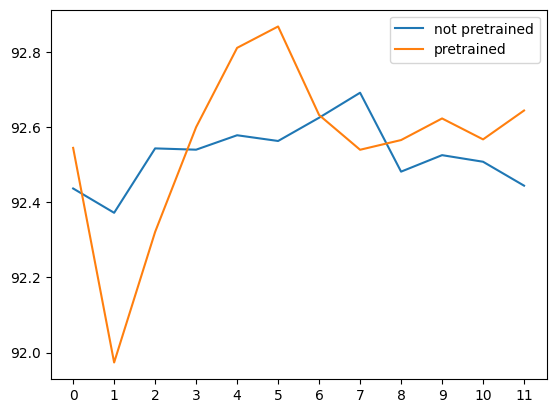

Dataset: en_6 - Features: dur


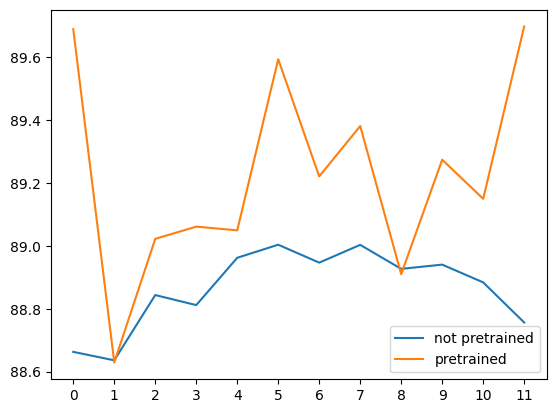

Dataset: en_6 - Features: firstrun_nfix


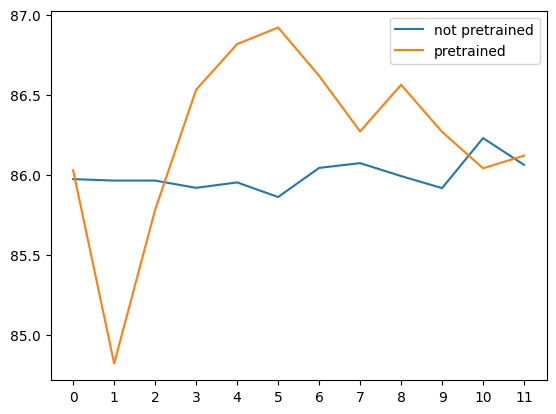

Dataset: en_6 - Features: nfix


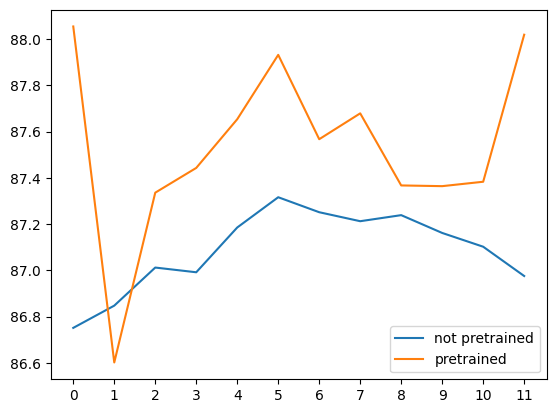

Dataset: en_6 - Features: refix


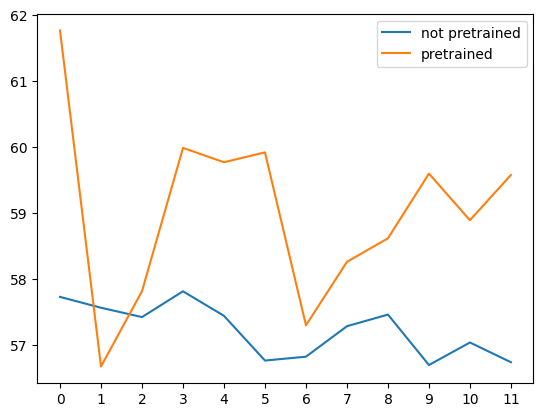

Dataset: en_6 - Features: reread


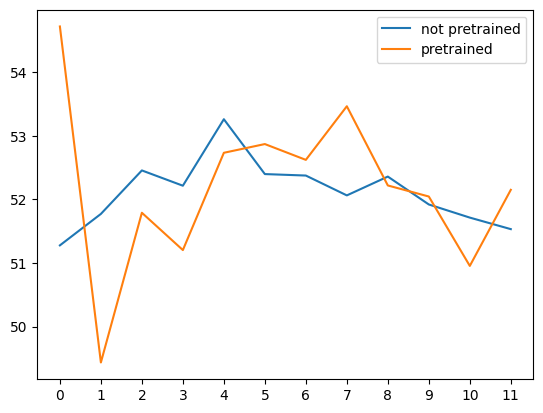

Dataset: en_49 - Features: skip


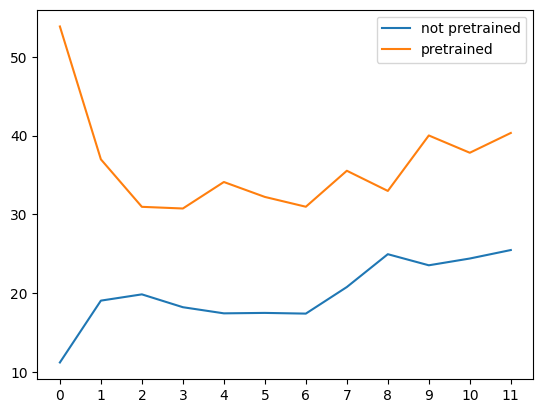

Dataset: en_49 - Features: firstfix_dur


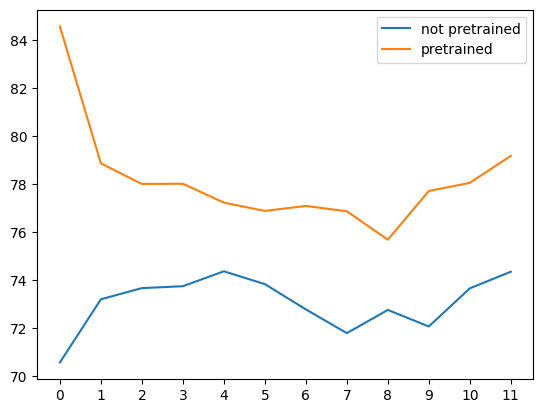

Dataset: en_49 - Features: firstrun_dur


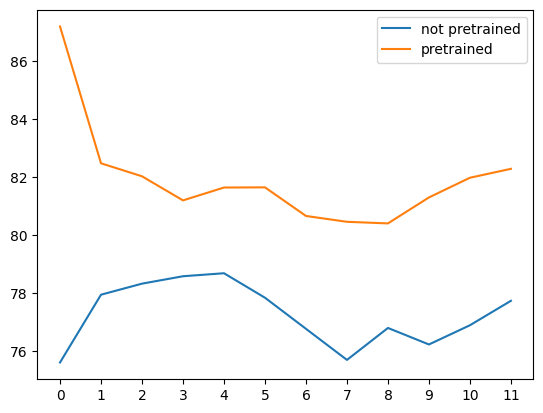

Dataset: en_49 - Features: dur


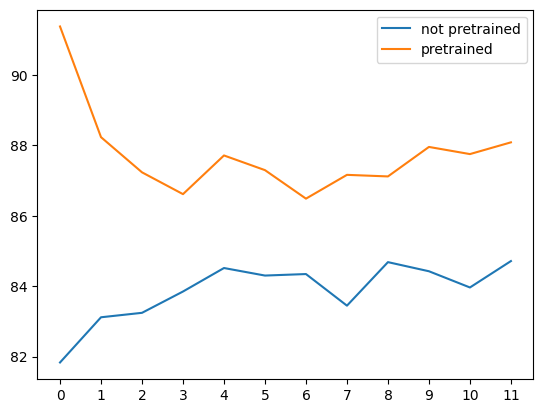

Dataset: en_49 - Features: firstrun_nfix


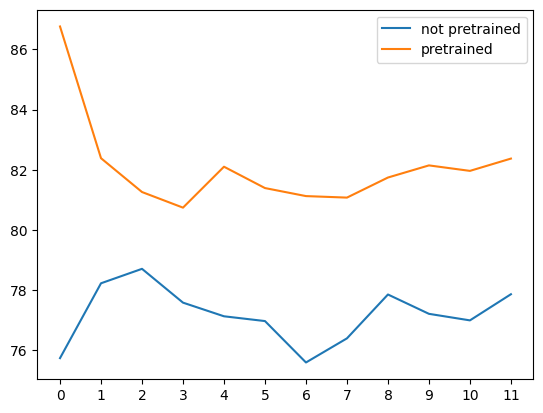

Dataset: en_49 - Features: nfix


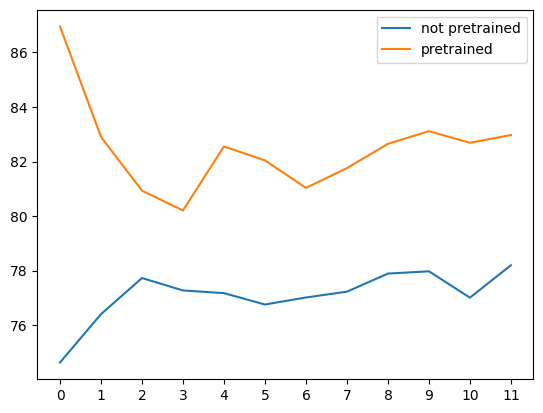

Dataset: en_49 - Features: refix


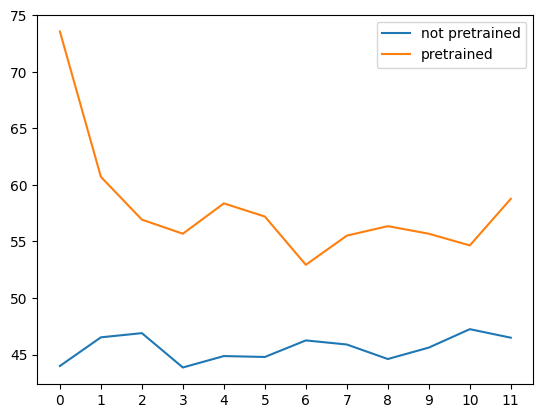

Dataset: en_49 - Features: reread


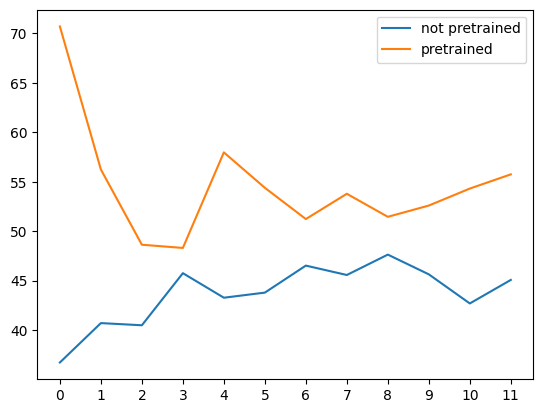

Dataset: it_44 - Features: skip


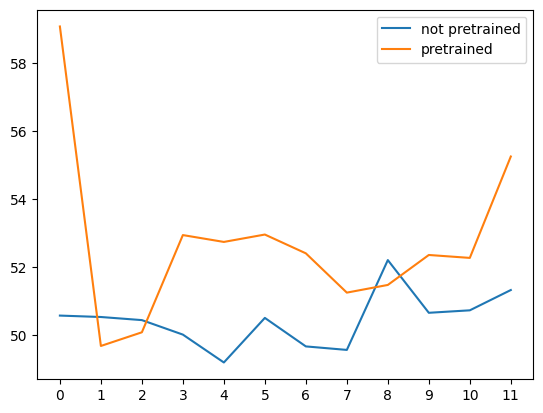

Dataset: it_44 - Features: firstfix_dur


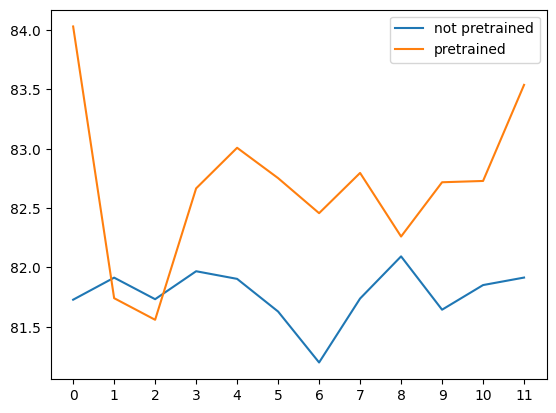

Dataset: it_44 - Features: firstrun_dur


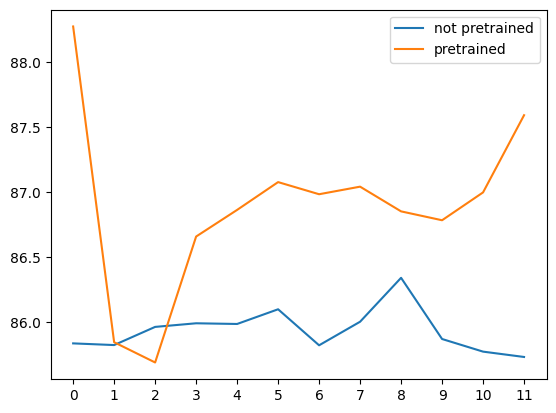

Dataset: it_44 - Features: dur


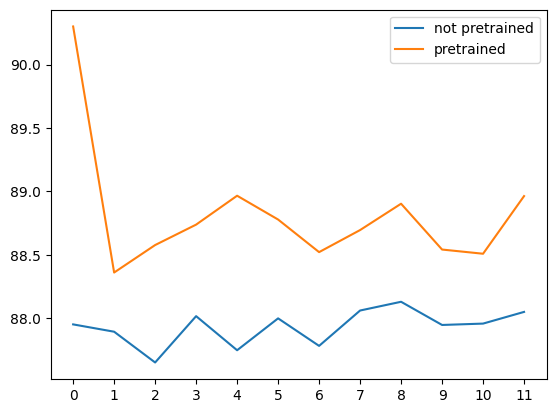

Dataset: it_44 - Features: firstrun_nfix


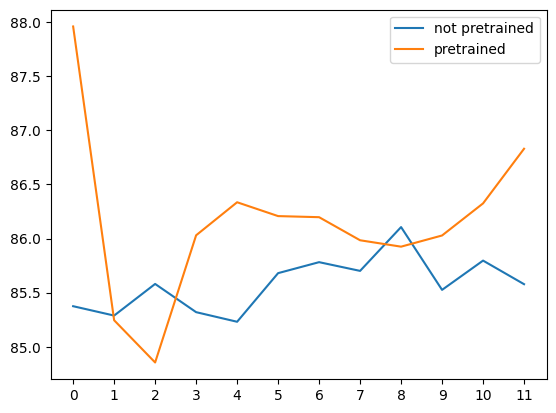

Dataset: it_44 - Features: nfix


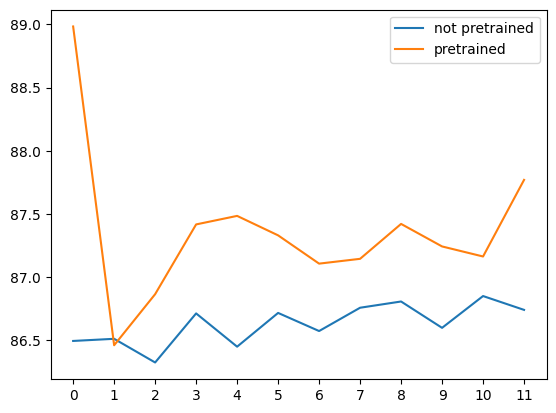

Dataset: it_44 - Features: refix


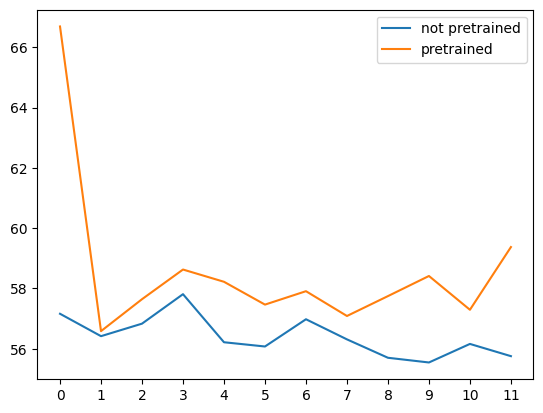

Dataset: it_44 - Features: reread


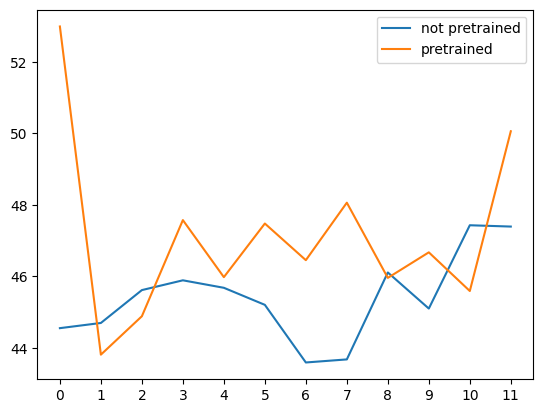

Dataset: en_98 - Features: skip


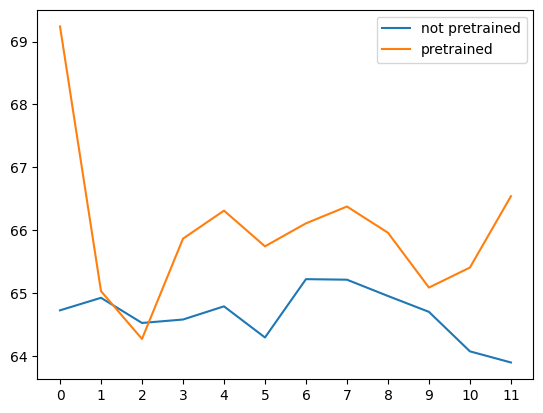

Dataset: en_98 - Features: firstfix_dur


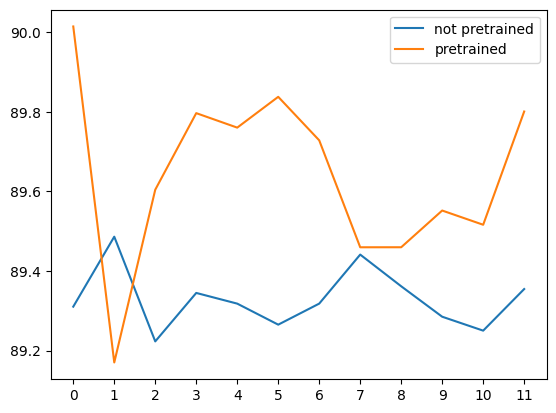

Dataset: en_98 - Features: firstrun_dur


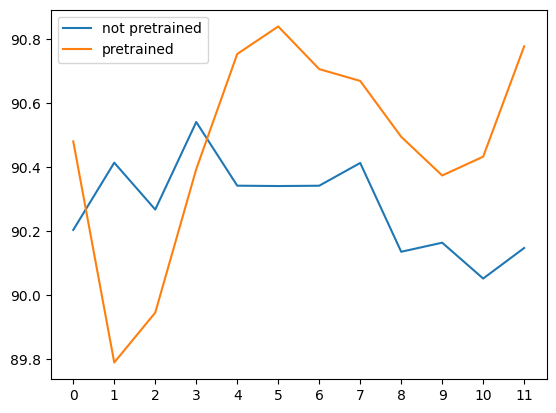

Dataset: en_98 - Features: dur


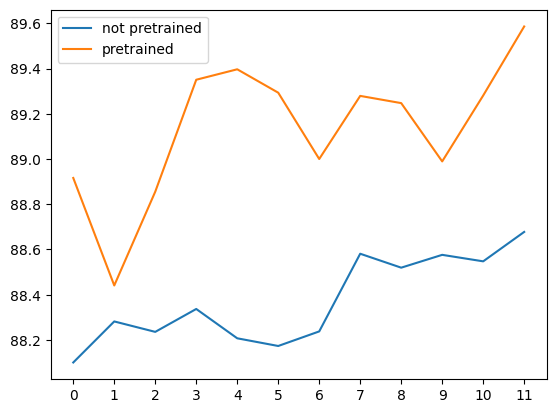

Dataset: en_98 - Features: firstrun_nfix


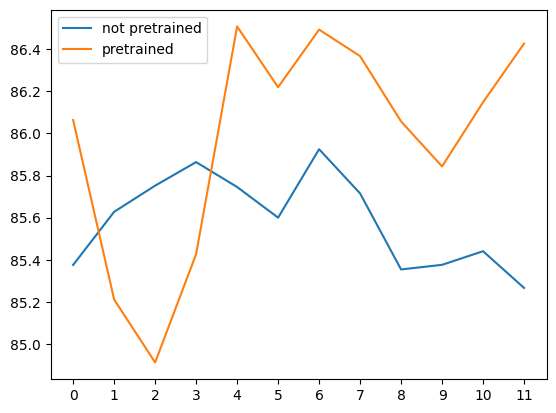

Dataset: en_98 - Features: nfix


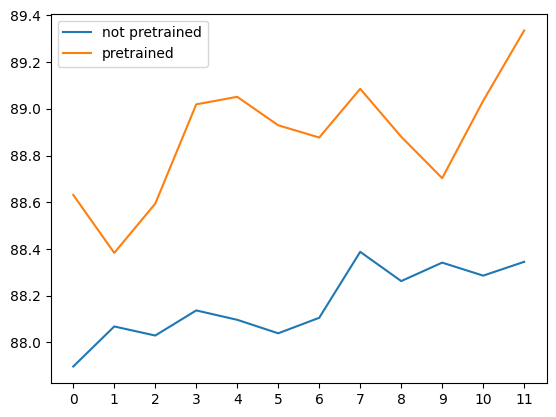

Dataset: en_98 - Features: refix


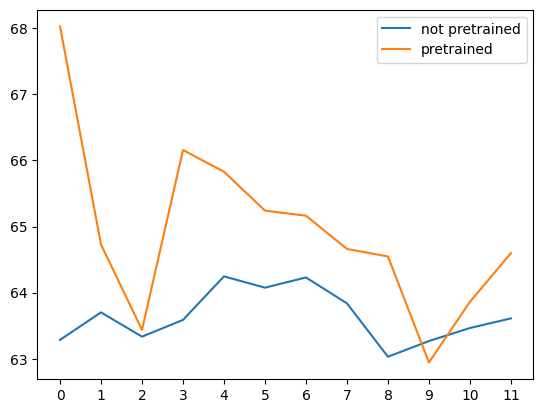

Dataset: en_98 - Features: reread


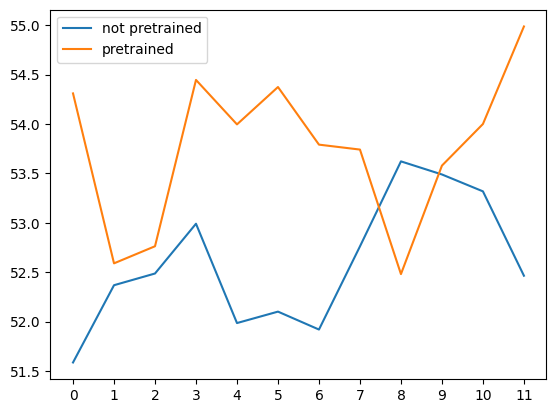

Dataset: en_83 - Features: skip


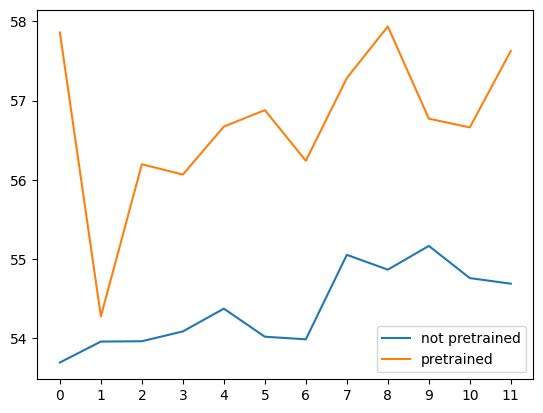

Dataset: en_83 - Features: firstfix_dur


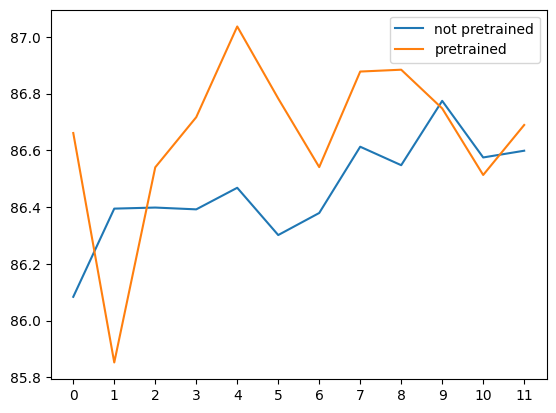

Dataset: en_83 - Features: firstrun_dur


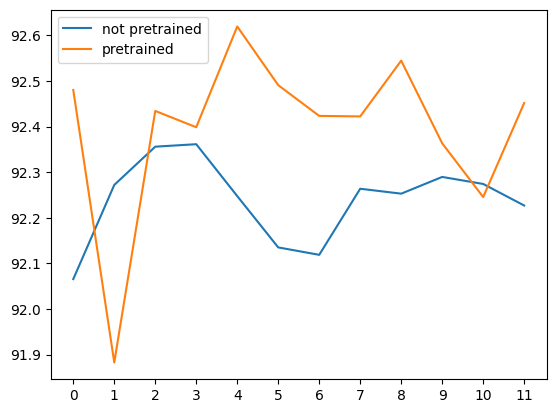

Dataset: en_83 - Features: dur


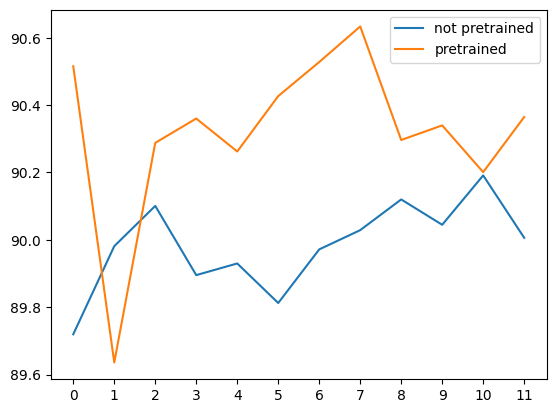

Dataset: en_83 - Features: firstrun_nfix


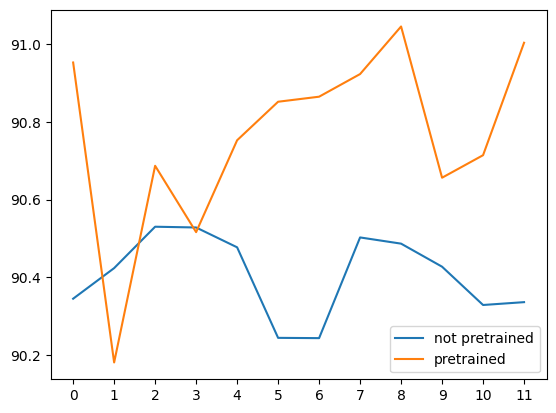

Dataset: en_83 - Features: nfix


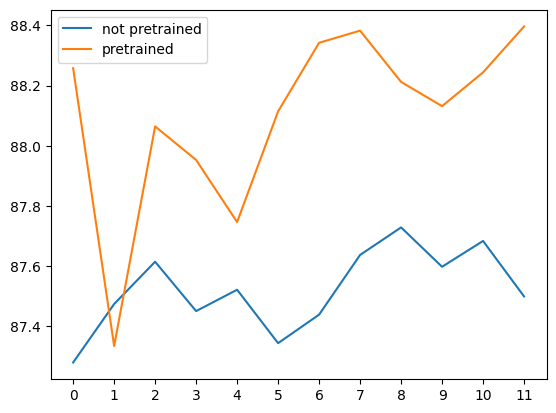

Dataset: en_83 - Features: refix


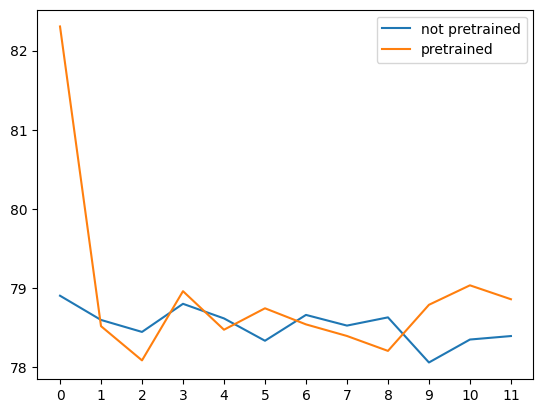

Dataset: en_83 - Features: reread


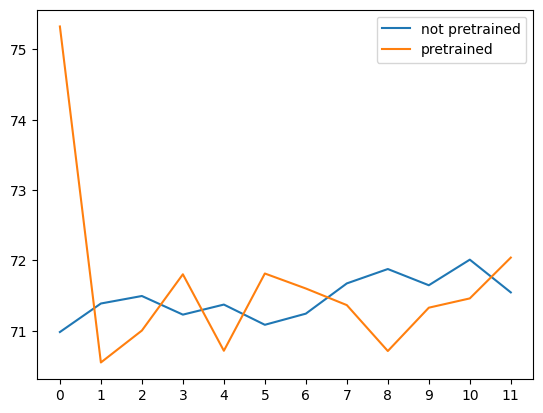

Dataset: it_1 - Features: skip


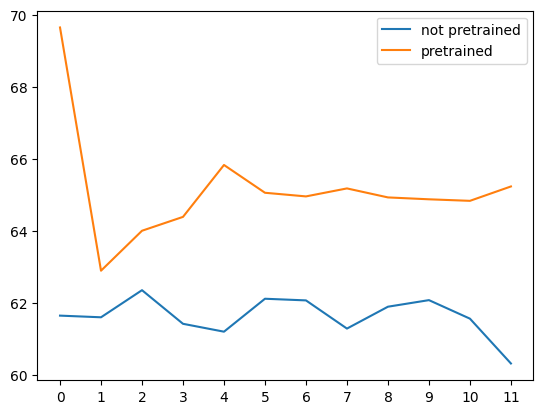

Dataset: it_1 - Features: firstfix_dur


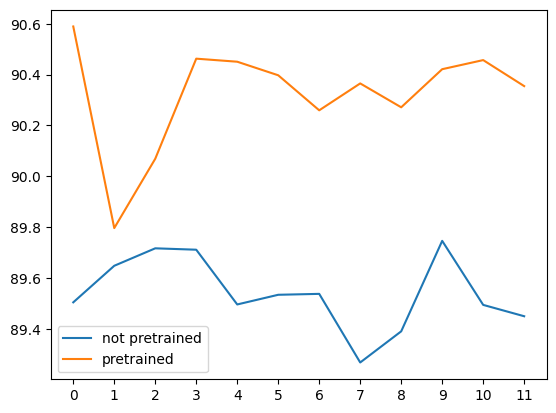

Dataset: it_1 - Features: firstrun_dur


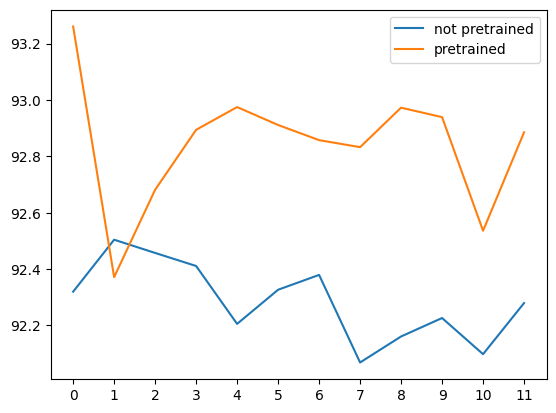

Dataset: it_1 - Features: dur


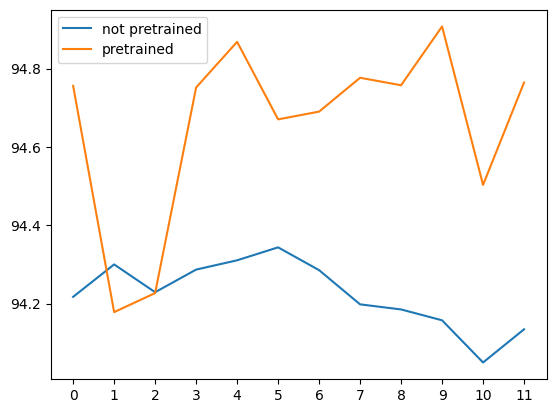

Dataset: it_1 - Features: firstrun_nfix


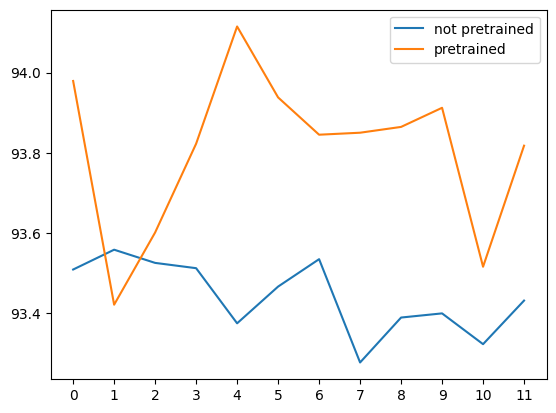

Dataset: it_1 - Features: nfix


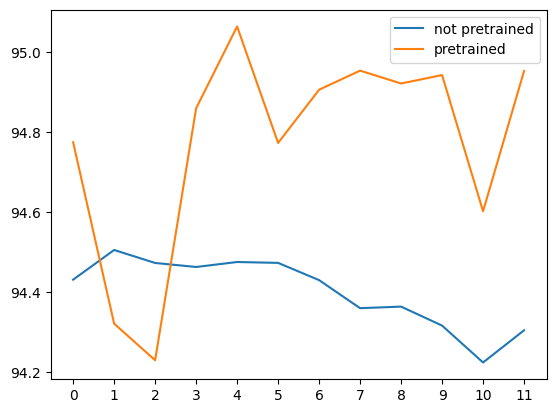

Dataset: it_1 - Features: refix


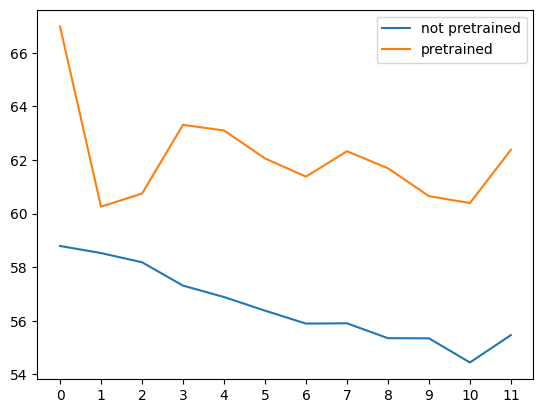

Dataset: it_1 - Features: reread


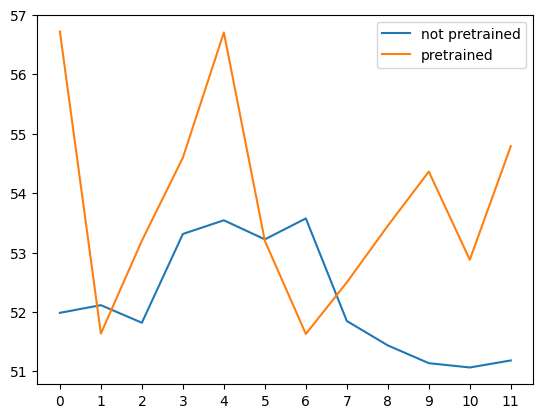

Dataset: it_38 - Features: skip


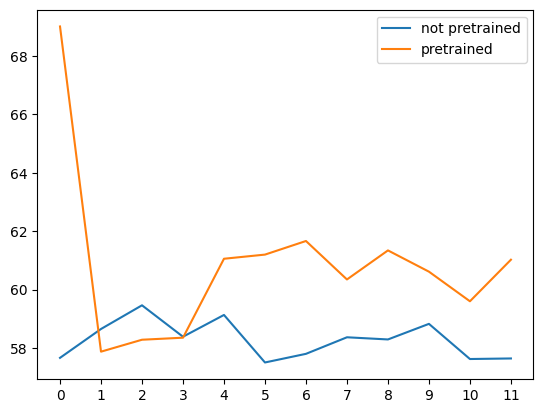

Dataset: it_38 - Features: firstfix_dur


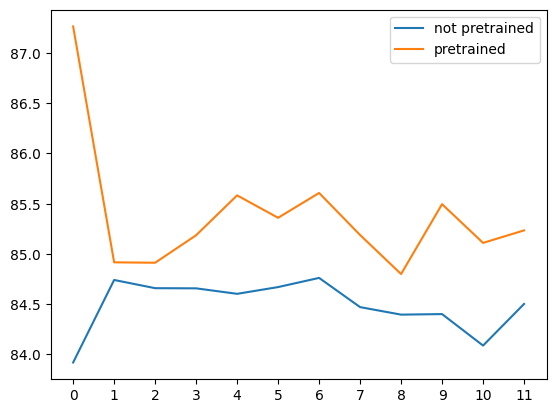

Dataset: it_38 - Features: firstrun_dur


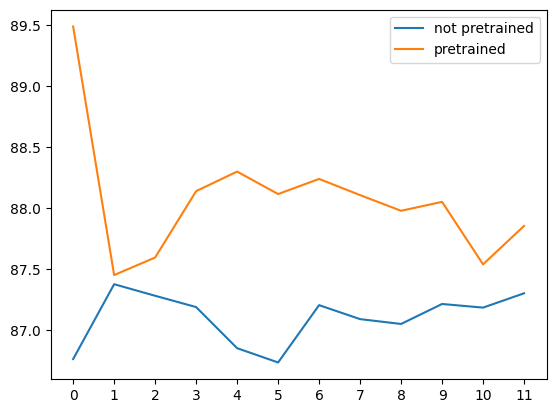

Dataset: it_38 - Features: dur


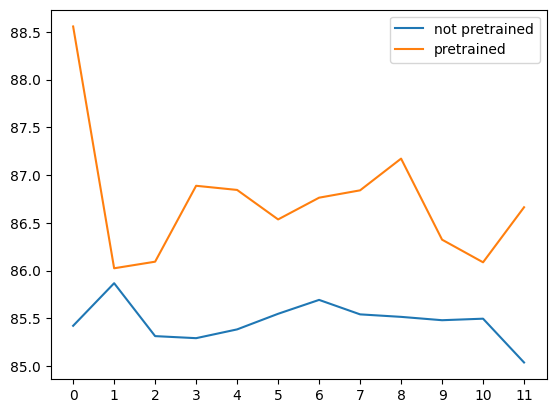

Dataset: it_38 - Features: firstrun_nfix


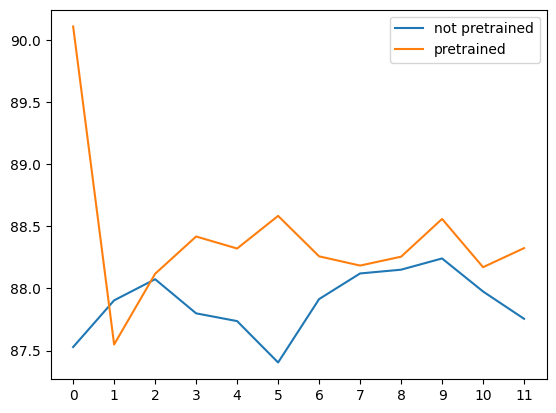

Dataset: it_38 - Features: nfix


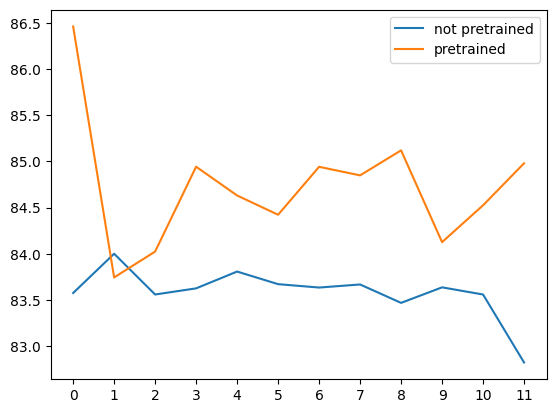

Dataset: it_38 - Features: refix


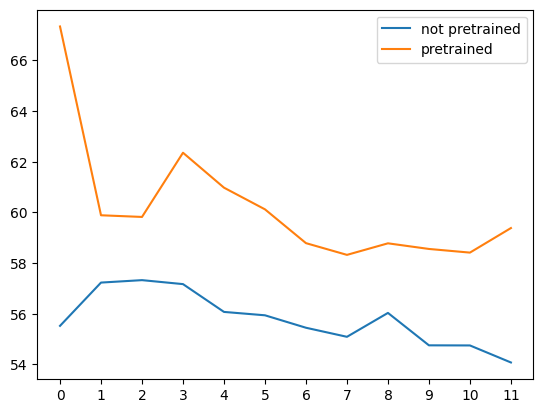

Dataset: it_38 - Features: reread


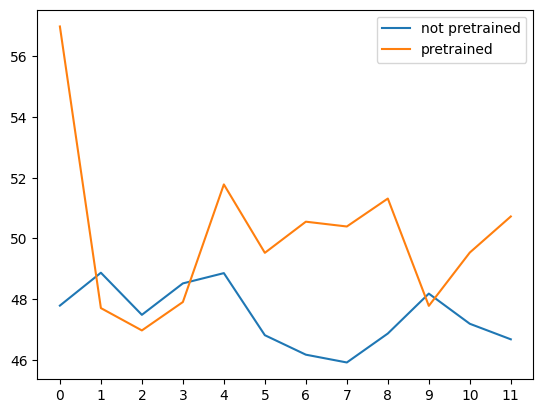

AVERAGED-Dataset: Features: skip


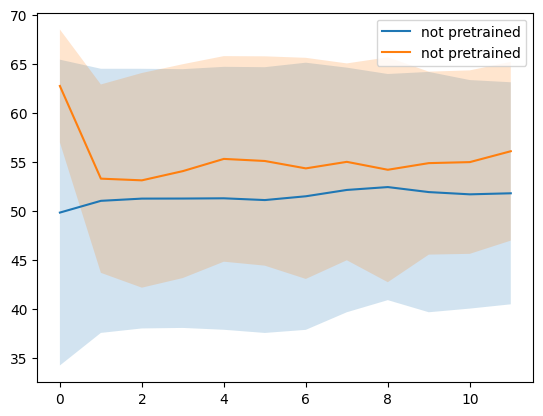

AVERAGED-Dataset: Features: firstfix_dur


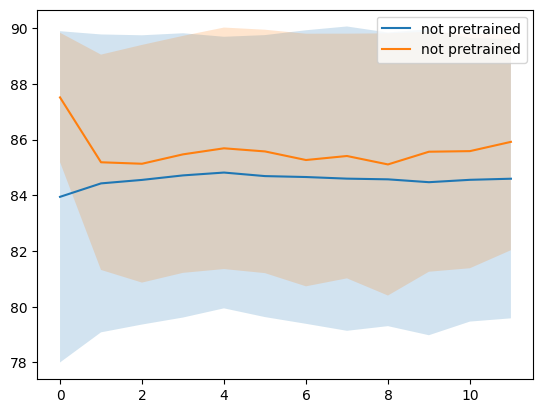

AVERAGED-Dataset: Features: firstrun_dur


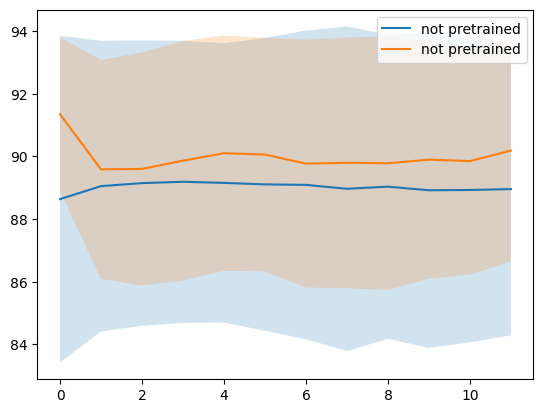

AVERAGED-Dataset: Features: dur


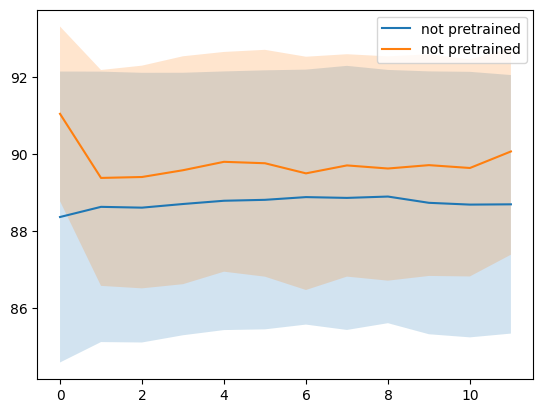

AVERAGED-Dataset: Features: firstrun_nfix


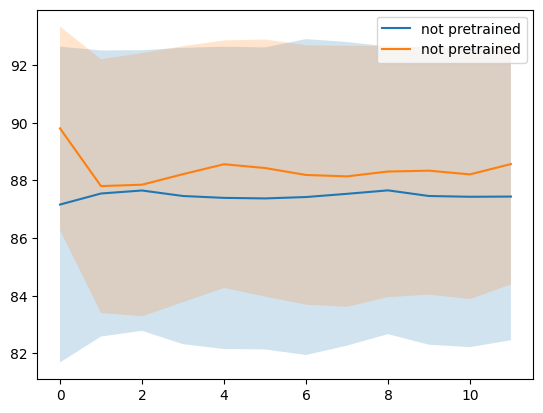

AVERAGED-Dataset: Features: nfix


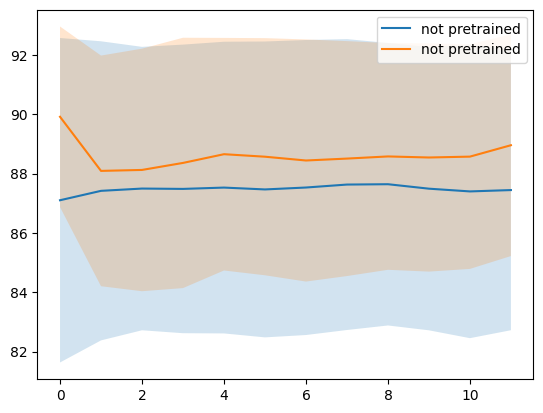

AVERAGED-Dataset: Features: refix


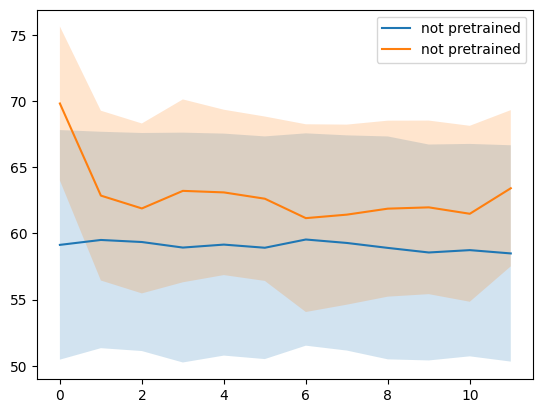

AVERAGED-Dataset: Features: reread


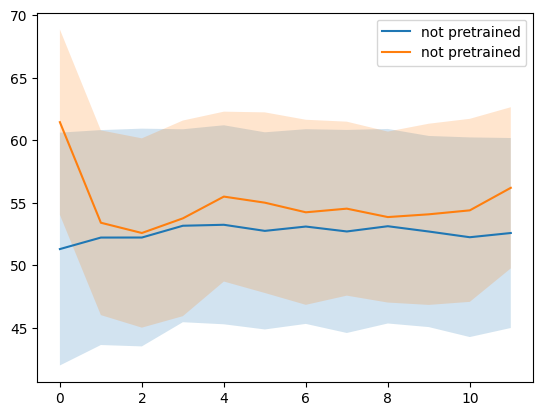

In [6]:
print_probe_results(dict_res_xlm)